# William Etzler ECON 4984 Assignment 3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

C:\Users\wetzl\AppData\Local\Temp\ipykernel_480\3027149247.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor

In [3]:
np.random.seed(11)

## Problem 1 a

In [21]:
grocery_path = r'C:\Users\wetzl\Desktop\Python\SSEcon\Data\Grocery.txt'
grocery = pd.read_csv(grocery_path, sep = '\t')
grocery.head()

,4264,305657,7.17,0
0,4496,328476,6.20,0
1,4317,317164,4.61,0
2,4292,366745,7.02,0
3,4945,265518,8.61,1
4,4325,301995,6.88,0


In [26]:
grocery.columns = ['Cases_Shipped', 'Indirect_Costs', 'Labor_Hours', 'Holiday']

X = grocery[['Cases_Shipped', 'Indirect_Costs', 'Holiday']]
Y = grocery['Labor_Hours']
X = sm.add_constant(X)  

model = sm.OLS(Y, X).fit()
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:            Labor_Hours   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.036
Method:                 Least Squares   F-statistic:                    0.4132
Date:                Tue, 30 Apr 2024   Prob (F-statistic):              0.744
Time:                        18:22:26   Log-Likelihood:                -65.004
No. Observations:                  51   AIC:                             138.0
Df Residuals:                      47   BIC:                             145.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              9.0517      3.742      2.

In [28]:
results_df = pd.DataFrame({
    'coef': model.params,
    'std err': model.bse,
    't': model.tvalues,
    'P>|t|': model.pvalues
})

RSS = model.ssr
df_resid = model.df_resid
sigma_squared_hat = RSS / df_resid

print("Regression Results Table:")
print(results_df)
print(f"\nEstimated variance of the error terms (sigma^2): {sigma_squared_hat:.6f}")

Regression Results Table:
                    coef   std err         t     P>|t|
const           9.051694  3.742288  2.418759  0.019499
Cases_Shipped  -0.000517  0.000906 -0.570480  0.571070
Indirect_Costs  0.000002  0.000002  0.698787  0.488129
Holiday         0.614378  0.684173  0.897986  0.373770

Estimated variance of the error terms (sigma^2): 0.812995


### Interpretaton of all statistical results:
1. Coefficients Estimation (coef)

    Intercept (const): The estimated coefficient is 9.051694, which is the expected value of labor hours when all other predictors are held constant at zero. It provides the baseline labor hours irrespective of the other factors.
    Cases_Shipped: The coefficient of -0.000517 suggests that for each additional case shipped, labor hours decrease slightly. However, this effect is very minimal.
    Indirect_Costs: The coefficient of 0.000002 indicates a tiny increase in labor hours for every unit increase in indirect costs. This effect is also minimal.
    Holiday: The coefficient of 0.614378 implies that labor hours increase by approximately 0.614 hours during holidays compared to non-holiday periods.

2. Standard Deviation of the Coefficients (std err)

    Intercept (const): The standard error is 3.742288, indicating the level of uncertainty or variability in the estimate of the intercept.
    Cases_Shipped: A standard error of 0.000906 shows the variability in the coefficient estimate of cases shipped.
    Indirect_Costs: A very low standard error of 0.000002, showing less variability in the estimate for indirect costs.
    Holiday: The standard error is 0.684173, which is relatively large compared to the coefficient size, indicating significant variability in the holiday effect estimate.

3. t-Statistics (t)

    Intercept (const): The t-value of 2.418759 indicates the number of standard deviations the estimated coefficient is away from zero. It suggests the significance of the intercept in the model.
    Cases_Shipped: A t-value of -0.570480 indicates the coefficient is not significantly different from zero, as it is within a reasonable range of zero in terms of standard errors.
    Indirect_Costs: A t-value of 0.698787 shows a similar non-significance.
    Holiday: The t-value of 0.897986 also indicates a non-significant difference from zero, despite being positive.

4. p-Values (P>|t|)

    Intercept (const): A p-value of 0.019499, which is less than 0.05, suggests that the intercept is statistically significant at the 5% level.
    Cases_Shipped: The p-value of 0.571070 shows that the coefficient is not statistically significant.
    Indirect_Costs: Similarly, a p-value of 0.488129 indicates non-significance.
    Holiday: A p-value of 0.373770 also indicates non-significance.

5. Estimated Variance of Error Terms (σ2)

    Sigma Squared (σ^2): The estimated variance of the error terms is 0.812995. This metric measures the variance in labor hours that is not explained by the model. A smaller σ2 would indicate a model that more accurately predicts labor hours. This value suggests that there remains a substantial amount of variability in labor hours that is not captured by the predictors in the model.

Conclusion:
The regression analysis reveals that the only significant predictor in the model is the intercept, indicating that other variables like cases shipped, indirect costs, and holidays do not significantly impact labor hours in the context of this dataset and model specification. The estimated variance of the error term is relatively high, suggesting that the model may not be adequately capturing all the influences on labor hours, or there could be other variables or interactions that would better explain the variability in labor hours.


## Problem 1 b

In [33]:
def forward_selection(data, response):
    initial_features = data.columns.tolist()
    best_features = []
    while len(initial_features) > 0:
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(data[response], sm.add_constant(data[best_features + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if min_p_value < 0.05:
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

selected_features = forward_selection(grocery, 'Labor_Hours')
print("Selected features using forward selection:")
print(selected_features)

Selected features using forward selection:
['Labor_Hours', 'Holiday']


## Problem 1 c

In [35]:
full_model = sm.OLS(grocery['Labor_Hours'], sm.add_constant(grocery[['Cases_Shipped', 'Indirect_Costs', 'Holiday']])).fit()

reduced_model = sm.OLS(grocery['Labor_Hours'], sm.add_constant(grocery[['Holiday']])).fit()

f_test = full_model.compare_f_test(reduced_model)
f_statistic, p_value, df_diff = full_model.compare_f_test(reduced_model)

print(f"F-statistic: {f_statistic}")
print(f"p-value: {p_value}")
print(f"Difference in degrees of freedom: {df_diff}")

F-statistic: 0.31752715547618193
p-value: 0.729496211359846
Difference in degrees of freedom: 2.0


### Interpretation of the F-test results:
The F-statistic does have an associated p-value greater than 0.05, which indicates that the full model is not statistically significantly better than the reduced model. This implies that the additional predictors (Cases_Shipped and Indirect_Costs) do not contribute significantly to the model's explanatory power compared to the reduced model with only the Holiday predictor. 

These results seem a bit odd, as the holidays don't necessarily correspond to productivity and thus labor hours. Maybe our model is not capturing the true relationship between the predictors and the response variable, which could be non-linear or involve interactions between the predictors.

## Problem 1 d

In [54]:
# Add predictors
grocery['Z1'] = grocery['Cases_Shipped'] * grocery['Indirect_Costs']
grocery['Z2'] = grocery['Cases_Shipped'] * grocery['Holiday']
grocery['Z3'] = grocery['Indirect_Costs'] * grocery['Holiday']
grocery['Z4'] = np.random.normal(loc=30, scale=30, size=len(grocery))
grocery['Z5'] = np.random.normal(loc=7, scale=1, size=len(grocery))

X_new = grocery[['Cases_Shipped', 'Indirect_Costs', 'Holiday', 'Z1', 'Z2', 'Z3', 'Z4', 'Z5']]
y = Y

In [67]:
# Create Lasso
alpha = 0.01  
lasso_model = Lasso(alpha=alpha, max_iter=50000, random_state=0)
lasso_model.fit(X_new, y)

# Cefficients
coefficients = lasso_model.coef_
formatted_coefficients = [format(coef, '.10f') for coef in coefficients]
print("Coefficeints:", formatted_coefficients)
# intercept
print("Intercept:", lasso_model.intercept_)

y_pred = lasso_model.predict(X_new)

# R-squared
r2 = r2_score(y, y_pred)
print("R-squared:", r2)

# Adjusted R-squared
n = len(y)  
p = X_new.shape[1]  
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print("Adjusted R-squared:", adjusted_r2)

# Residual Standard Error
rss = np.sum((y_pred - y) ** 2)
df_resid = n - p - 1
residual_std_error = np.sqrt(rss / df_resid)
print("Residual Standard Error:", residual_std_error)


Coefficeints ['-0.0070462271', '-0.0000975993', '-0.0000000000', '0.0000000228', '0.0008087298', '-0.0000117865', '0.0024215402', '0.0869237434']
Intercept: 36.742214611126435
R-squared: 0.07825367941463224
Adjusted R-squared: -0.09731704831591403
Residual Standard Error: 0.9277401336466867


The model does not appear to be particularly effective at predicting Labor_Hours based on the provided predictors and the regularization applied. The combination of low R-squared, negative adjusted R-squared, and non-significant coefficients for most variables suggests that either the variables included are not the right predictors, or the model needs re-evaluation perhaps with different features or another modeling approach.

## Problem 2

In [3]:
spam_path = r'C:\Users\wetzl\Desktop\Python\SSEcon\Data\SPAM.csv'
spamd = pd.read_csv(spam_path)
spamd.head()

,spam,testid,make,address,all,3d,our,over,remove,internet,...,conference,ch;,ch(,ch[,ch!,ch$,ch#,crl.ave,crl.long,crl.tot
0,True,True,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,...,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278
1,True,False,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,...,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028
2,True,True,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,...,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259
3,True,False,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,...,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191
4,True,False,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,...,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191


In [69]:
train_data = spamd[spamd['testid'] == False]
test_data = spamd[spamd['testid'] == True]

X_train = train_data.drop(columns=['spam', 'testid'])
y_train = train_data['spam']
X_test = test_data.drop(columns=['spam', 'testid'])
y_test = test_data['spam']

# Standardize 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [70]:
Cs = np.logspace(-4, 4, 30)

misclassification_errors = []

# Perform Lasso Logistic Regression with cross-validation for each C
for C in Cs:
    model = LogisticRegression(penalty='l1', C=C, solver='liblinear', max_iter=10000)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    misclassification_error = 1 - accuracy_score(y_test, y_pred)
    misclassification_errors.append(misclassification_error)

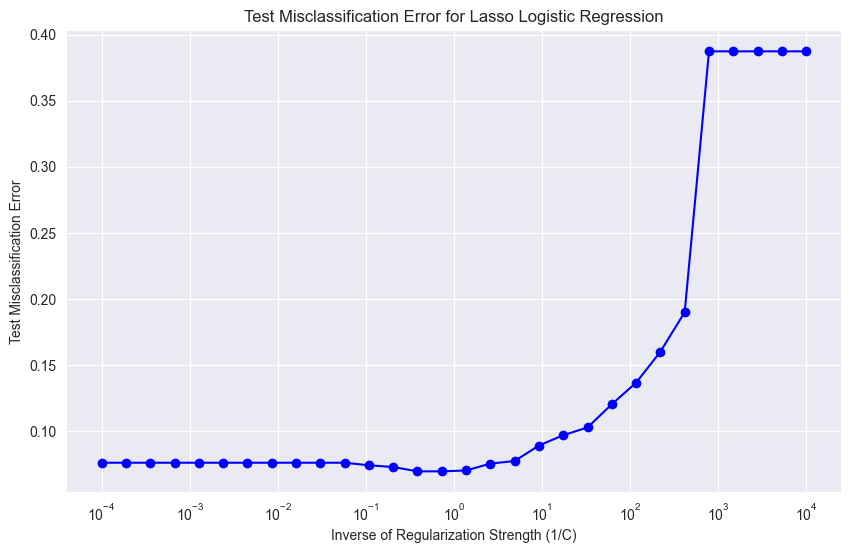

In [71]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(1/Cs, misclassification_errors, marker='o', linestyle='-', color='blue')
plt.xscale('log')
plt.xlabel('Inverse of Regularization Strength (1/C)')
plt.ylabel('Test Misclassification Error')
plt.title('Test Misclassification Error for Lasso Logistic Regression')
plt.grid(True)
plt.show()


## Problem 3 a

In [3]:
als_path = r'C:\Users\wetzl\Desktop\Python\SSEcon\Data\ALS.txt'
als = pd.read_csv(als_path, delimiter=' ')
als.head()

,testset,dFRS,Onset.Delta,Symptom.Speech,Symptom.WEAKNESS,Symptom.OTHER,Symptom.Swallowing,Symptom.GAIT_CHANGES,Symptom.Atrophy,Symptom.Cramps,...,max.slope.bp.systolic,min.slope.bp.systolic,last.slope.bp.systolic,mean.slope.bp.systolic,num.slope.bp.systolic.visits,sum.slope.bp.systolic,first.slope.bp.systolic.date,meansquares.slope.bp.systolic,sd.slope.bp.systolic,slope.bp.systolic.slope
0,True,-0.915388,-1181,1,0,0,1,0,0,0,...,0.981828,-8.300909,0.000000,-2.439694,3,-7.319081,5.5,23.289693,4.163843,5.003010
1,True,-0.107931,-1324,0,1,0,0,0,0,0,...,0.000000,-9.818280,-9.818280,-4.909140,2,-9.818280,18.0,48.199307,4.909140,-8.920469
2,True,-0.557448,-1061,0,0,0,0,0,0,0,...,6.522143,-5.533939,6.522143,0.494102,2,0.988203,11.0,36.581416,6.028041,14.677878
3,True,-0.296461,-1736,0,1,0,0,0,0,0,...,55.800556,-87.928148,10.145556,-8.606468,7,-60.245275,4.5,1842.174361,42.048818,41.458842
4,True,-1.087024,-354,1,0,0,0,0,0,0,...,6.917424,-10.870238,6.917424,-1.317605,3,-3.952814,6.0,55.337611,7.321307,3.759702


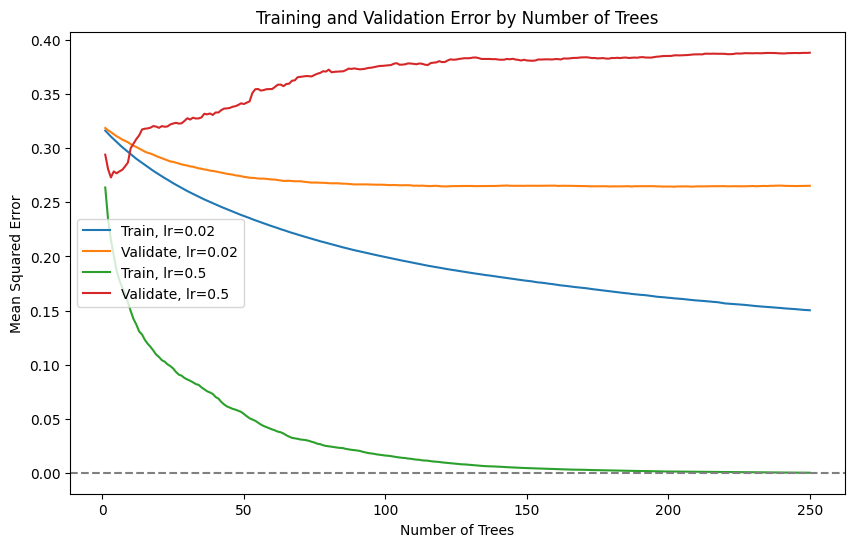

In [5]:
als_train2 = als[als['testset'] == False]
als_test2 = als[als['testset'] == True]

X_train2 = als_train2.drop(columns=['dFRS', 'testset'])
y_train2 = als_train2['dFRS']
X_test2 = als_test2.drop(columns=['dFRS', 'testset'])
y_test2 = als_test2['dFRS']

# Learning rates and number of estimators
learning_rates = [0.02, 0.5]
n_estimators = 250
train_errors2 = {lr: [] for lr in learning_rates}
val_errors2 = {lr: [] for lr in learning_rates}

for lr in learning_rates:
    model2 = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=lr, max_depth=3, random_state=42)
    model2.fit(X_train2, y_train2)
    
    # Record the training and validation errors for each number of trees
    for i, y_pred in enumerate(model2.staged_predict(X_train2)):
        train_errors2[lr].append(mean_squared_error(y_train2, y_pred))
        
    for i, y_pred in enumerate(model2.staged_predict(X_test2)):
        val_errors2[lr].append(mean_squared_error(y_test2, y_pred))

# Plot 
plt.figure(figsize=(10, 6))
for lr in learning_rates:
    plt.plot(np.arange(1, n_estimators + 1), train_errors2[lr], label=f'Train, lr={lr}')
    plt.plot(np.arange(1, n_estimators + 1), val_errors2[lr], label=f'Validate, lr={lr}')

plt.title('Training and Validation Error by Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

### Interpretation of the results:
The graph demonstrates that the learning rate (ε) significantly affects the convergence and generalization of gradient boosting models. A lower ε (0.02) results in slower, more stable error reduction across more trees, enhancing model generalization without overfitting. In contrast, a higher ε (0.5) leads to rapid initial decreases in training error but soon plateaus, increasing the risk of overfitting. As a tuning parameter, ε controls the step size in the boosting process, balancing the speed of learning against the risk of fitting noise in the training data.

## Problem 3 b

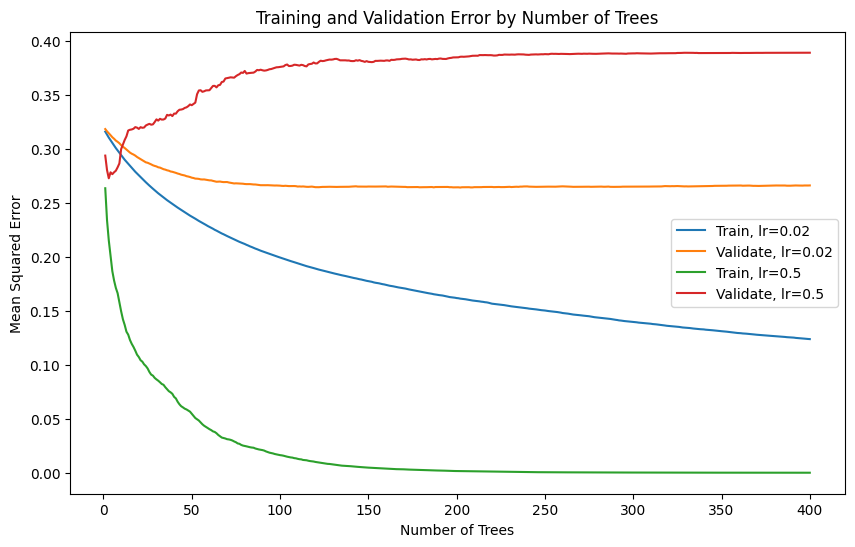

In [6]:
n_estimators = 400  # Increasing from 250 to 400

train_errors2 = {lr: [] for lr in learning_rates}
val_errors2 = {lr: [] for lr in learning_rates}

for lr in learning_rates:
    model2 = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=lr, max_depth=3, random_state=42)
    model2.fit(X_train2, y_train2)
    
    for i, y_pred in enumerate(model2.staged_predict(X_train2)):
        train_errors2[lr].append(mean_squared_error(y_train2, y_pred))
    for i, y_pred in enumerate(model2.staged_predict(X_test2)):
        val_errors2[lr].append(mean_squared_error(y_test2, y_pred))

plt.figure(figsize=(10, 6))
for lr in learning_rates:
    plt.plot(np.arange(1, n_estimators + 1), train_errors2[lr], label=f'Train, lr={lr}')
    plt.plot(np.arange(1, n_estimators + 1), val_errors2[lr], label=f'Validate, lr={lr}')

plt.title('Training and Validation Error by Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

Not sure the purpose of that, it was already pretty well converged at 250 trees.

## Problem 3 c

In [ ]:
# Settings
n_estimators = 2500
oob_errors_rf = []
oob_errors_bagging = []

# Random Forest
rf = RandomForestRegressor(n_estimators=1, oob_score=True, random_state=42, warm_start=True, bootstrap=True)
for i in range(1, n_estimators + 1):
    rf.n_estimators = i
    rf.fit(X_train2, y_train2)  
    if len(rf.oob_prediction_) > 0:  
        oob_error = 1 - rf.oob_score_
        oob_errors_rf.append(oob_error)
    else:
        oob_errors_rf.append(None)  

# Bagging
bagging = BaggingRegressor(n_estimators=1, oob_score=True, random_state=42, warm_start=True, bootstrap=True)
for i in range(1, n_estimators + 1):
    bagging.n_estimators = i
    bagging.fit(X_train2, y_train2)
    if len(bagging.oob_prediction_) > 0:
        oob_error = 1 - bagging.oob_score_
        oob_errors_bagging.append(oob_error)
    else:
        oob_errors_bagging.append(None)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, n_estimators + 1), oob_errors_rf, label='Random Forest OOB Error', marker='o', linestyle='-', linewidth=1)
plt.plot(np.arange(1, n_estimators + 1), oob_errors_bagging, label='Bagging OOB Error', marker='o', linestyle='-', linewidth=1)
plt.title('OOB Error vs. Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('OOB Error')
plt.legend()
plt.show()

C:\Users\wetzl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\wetzl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\wetzl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\wetzl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\wetzl\A

In [4]:
# Issues with 3 c